# 1. Introduction

- Name: Audrey Wanto
- Batch: BSD 002
- Dataset: [California Independent Medical Review Dataset](https://www.kaggle.com/datasets/prasad22/ca-independent-medical-review)
- Problem Statement: The dataset originated from the California Department of Managed Health Care (DMHC). This data set is used to determine whether a patient is classified into the three categories of "medically necessary", "experimental/investigational" or "non-emergent/urgent". The categories are classified through the Reviews done by official administrations, and if the patient is classified into certain categories, they must authorize the service or treatment as health services are not mandatory.
- Objective: The objective is to create an Artificial Neural Network through the model of Natural Language Processing to predict the classification of a patient through the summary.

# 2. Import Libraries

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
import warnings
import shutil
import os
from google.colab import files
warnings.filterwarnings('ignore')

# EDA
from wordcloud import WordCloud
from collections import Counter

# ANN
import tensorflow as tf
import tensorflow_hub as tf_hub

# Feature Engineering
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Modelling
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, Input, LSTM, GRU, Dropout, Reshape, BatchNormalization, TextVectorization
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

# Download files
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 3. Data Loading

In [2]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install Kaggle
!pip install kaggle

In [4]:
# create kaggle directory
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
# copy kaggle.json new directory
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle

In [6]:
# Download Dataset from Kaggle
!kaggle datasets download -d prasad22/ca-independent-medical-review

ca-independent-medical-review.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# Unzip dataset
!unzip -q '/content/ca-independent-medical-review.zip' -d dataset

replace dataset/Independent_Medical_Review__IMR__Determinations__Trend.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [8]:
# Create path for dataset
data_path = '/content/dataset/Independent_Medical_Review__IMR__Determinations__Trend.csv'

In [9]:
# Create Dataframe for the dataset
df_ori = pd.read_csv(data_path)

# Duplicate original dataset
df_1 = df_ori.copy()

In [10]:
# Show top 10 dataset
df_1.head(10)

,Reference ID,Report Year,Diagnosis Category,Diagnosis Sub Category,Treatment Category,Treatment Sub Category,Determination,Type,Age Range,Patient Gender,Findings
0,MN16-22639,2016,Infectious,Hepatitis,Pharmacy/Prescription Drugs,Anti-virals,Overturned Decision of Health Plan,Medical Necessity,41-50,Male,Nature of Statutory Criteria/Case Summary: An ...
1,MN16-22638,2016,Mental,Eating Disorder,Mental Health Treatment,Residential Treatment Center - Admission,Upheld Decision of Health Plan,Medical Necessity,21-30,Female,Nature of Statutory Criteria/Case Summary: An...
2,MN16-22637,2016,Autism Spectrum,Autism-PDD-NOS,Autism Related Treatment,Speech Therapy,Upheld Decision of Health Plan,Medical Necessity,0-10,Female,Nature of Statutory Criteria/Case Summary: Th...
3,EI16-22636,2016,Prevention/Good Health,NaN,"Diagnostic Imaging, Screening and Testing",Mammography,Overturned Decision of Health Plan,Experimental/Investigational,65+,Female,Nature of Statutory Criteria/Case Summary: An ...
4,EI06-5319,2006,Cardiac/Circulatory,NaN,Cardio Vascular,NaN,Upheld Decision of Health Plan,Experimental/Investigational,51-64,Male,Physician 1: The patient is a 62-year-old male...
5,EI16-22635,2016,Prevention/Good Health,NaN,"Diagnostic Imaging, Screening and Testing",Lab Work,Upheld Decision of Health Plan,Experimental/Investigational,21-30,Male,Nature of Statutory Criteria/Case Summary: An...
6,EI16-22634,2016,OB-Gyn/ Pregnancy,Female Breast Disorder,"Diagnostic Imaging, Screening and Testing",Mammography,Overturned Decision of Health Plan,Experimental/Investigational,65+,Female,Nature of Statutory Criteria/Case Summary: An...
7,EI16-22633,2016,OB-Gyn/ Pregnancy,Female Breast Disorder,"Diagnostic Imaging, Screening and Testing",Mammography,Overturned Decision of Health Plan,Experimental/Investigational,51-64,Female,Nature of Statutory Criteria/Case Summary: An...
8,MN16-22632,2016,Autism Spectrum,Autism-PDD-NOS,Autism Related Treatment,Speech Therapy,Upheld Decision of Health Plan,Medical Necessity,0-10,Male,Nature of Statutory Criteria/Case Summary: T...
9,EI16-22158,2016,Digestive System/ Gastrointestinal,Other,"Diagnostic Imaging, Screening and Testing",Allergy Testing,Upheld Decision of Health Plan,Experimental/Investigational,11_20,Female,Nature of Statutory Criteria/Case Summary: T...


In [11]:
# Show bottom 10 dataset
df_1.tail(10)

,Reference ID,Report Year,Diagnosis Category,Diagnosis Sub Category,Treatment Category,Treatment Sub Category,Determination,Type,Age Range,Patient Gender,Findings
19235,MN01-12,2001,Infectious,Lyme Disease,Pharmacy/Prescription Drugs,Antibiotics,Upheld Decision of Health Plan,Medical Necessity,NaN,NaN,A 51-year-old female requested continued utili...
19236,MN01-11,2001,Orthopedic/ Musculoskeletal,Other,"Diagnostic Imaging, Screening and Testing",Other,Upheld Decision of Health Plan,Medical Necessity,NaN,NaN,A 63-year-old female requested Electromyograph...
19237,MN01-10,2001,"Ears, Nose, Throat",Enlarged Turbinates,Electrical/ Thermal/ Radiofreq. Interventions,Radiofrequency Ablation,Upheld Decision of Health Plan,Medical Necessity,NaN,NaN,A 52-year-old female requested Radiofrequency ...
19238,MN01-9,2001,Infectious,Onychomycosis/ Nail Fungus,Pharmacy/Prescription Drugs,Anti-Fungal,Overturned Decision of Health Plan,Medical Necessity,NaN,NaN,A 46-year-old male requested the prescription ...
19239,MN01-8,2001,OB-Gyn/ Pregnancy,Menopause,Pharmacy/Prescription Drugs,Formulary versus Non-Formulary,Overturned Decision of Health Plan,Medical Necessity,NaN,NaN,A 48-year old female requested the prescriptio...
19240,MN01-7,2001,Trauma/Injuries,Gunshot Wound,Neurosugery,Cranioplasty,Overturned Decision of Health Plan,Medical Necessity,NaN,NaN,The parents of a 17-year-old male requested a ...
19241,MN01-6,2001,Infectious,Onychomycosis/ Nail Fungus,Pharmacy/Prescription Drugs,Anti-Fungal,Upheld Decision of Health Plan,Medical Necessity,NaN,NaN,A 46-year-old male requested Penlac lacquer fo...
19242,MN01-5,2001,Orthopedic/ Musculoskeletal,Other,Orthopedic,Arthroscopy,Upheld Decision of Health Plan,Medical Necessity,NaN,NaN,A 46-year-old female requested an orthoscopic ...
19243,MN01-4,2001,Orthopedic/ Musculoskeletal,Back Pain,Reconstructive/Plastic Surgery,Breast Reduction,Overturned Decision of Health Plan,Medical Necessity,NaN,NaN,A 24-year-old female requested a bilateral bre...
19244,EI01-3,2001,Cancer,Lung Cancer,Cancer Treatment,Clinical Trial (Phase 1),Upheld Decision of Health Plan,Experimental/Investigational,NaN,NaN,A male requested participation in a Phase I st...


In [12]:
# Checking for data information
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19245 entries, 0 to 19244
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Reference ID            19245 non-null  object
 1   Report Year             19245 non-null  int64 
 2   Diagnosis Category      19186 non-null  object
 3   Diagnosis Sub Category  17341 non-null  object
 4   Treatment Category      18795 non-null  object
 5   Treatment Sub Category  17977 non-null  object
 6   Determination           19245 non-null  object
 7   Type                    19245 non-null  object
 8   Age Range               18035 non-null  object
 9   Patient Gender          18035 non-null  object
 10  Findings                19225 non-null  object
dtypes: int64(1), object(10)
memory usage: 1.6+ MB


In [13]:
# Show column names from df_1
df_1.columns

Index(['Reference ID', 'Report Year', 'Diagnosis Category',
       'Diagnosis Sub Category', 'Treatment Category',
       'Treatment Sub Category', 'Determination', 'Type', 'Age Range',
       'Patient Gender', 'Findings'],
      dtype='object')

From the information above, there are a total of 11 columns, and 19225 rows. Some columns such as `Diagnosis Category`, `Diagnosis Sub Category`, `Treatment Category`, `Treatment Sub Category`, `Age Range`, `Patient Gender`, and `Findings` have missing values which will later be dropped. The important columns that will be used are `Type` and `Findings`.

### Data Description

| Column | Description | Data Type |
| ------ | ----------- |-----------|
| Reference ID | Reference ID of patient | Object |
| Report Year | Year data was taken | Int64 |
| Diagnosis Category | Category of Diagnosis | Object |
| Diagnosis Sub Category | Sub Category of Diagnosis | Object |
| Treatment Category | Category of Treatment | Object |
| Treatment Sub Category | Sub Category of Treatment | Object |
| Determination | Determination of patient | Object |
| Type | Type of urgency of the patient | Object |
| Age Range | Range of age of the patient | Object |
| Patient Gender | Gender of the patient | Object |
| Findings | Summary of the patient's medical condition | Object |

As the data type matches the data type from df.info(), there are no changed needed to be done.

# 4. Exploratory Data Analysis

Text(0.5, 1.0, 'Pie Chart of Type')

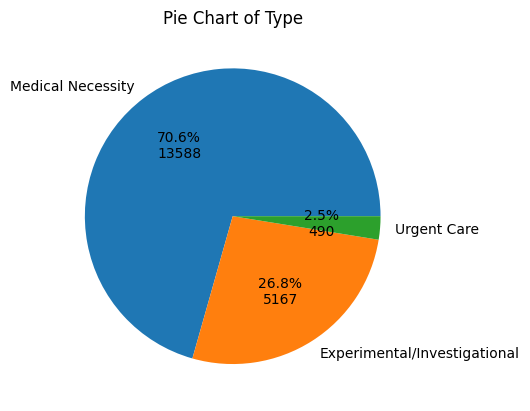

In [14]:
# Pie chart for 'Type'
type_total = df_1['Type'].value_counts().values.sum()
def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, type_total*x/100)
plt.pie(df_1['Type'].value_counts().values, labels=df_1['Type'].value_counts().index, autopct=fmt)
plt.title('Pie Chart of Type')

From the pie chart above, majority of the data are classified into "Medical Necessity" with 70.6% (13588), 36.8% (5167) goes to "Experimental/Investigational", and minority of 2.5% (490) into "Urgent care".

Text(0.5, 1.0, 'Pie Chart of Patient Gender')

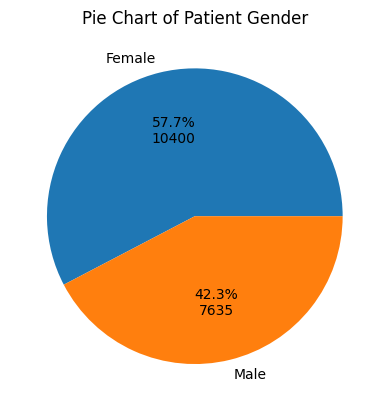

In [15]:
# Pie chart for 'Patient Gender'
gender_total = df_1['Patient Gender'].value_counts().values.sum()
def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, gender_total*x/100)
plt.pie(df_1['Patient Gender'].value_counts().values, labels=df_1['Patient Gender'].value_counts().index, autopct=fmt)
plt.title('Pie Chart of Patient Gender')

While although there are more female than male patients overall, it does not seem as gender affects the 'Type' a patient will get categorized into.

Text(0.5, 1.0, 'Pie Chart of Determination')

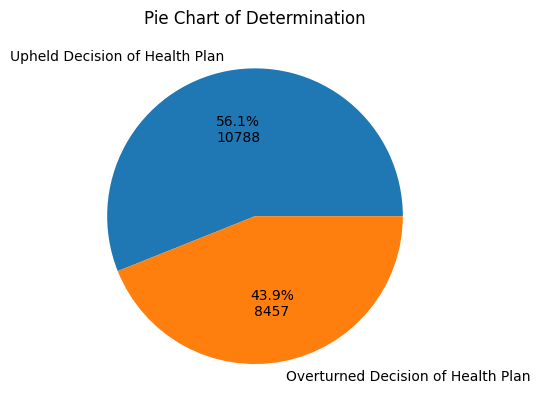

In [16]:
# Pie chart for 'Determination'
determination_total = df_1['Determination'].value_counts().values.sum()
def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, determination_total*x/100)
plt.pie(df_1['Determination'].value_counts().values, labels=df_1['Determination'].value_counts().index, autopct=fmt)
plt.title('Pie Chart of Determination')

There are only two different types of 'Determination', which is the rate of which the patient goes along with the health plan provided. More than half (56.1%) approved of the health plan, while 43.9% did not agree with the health plan.

In [17]:
# Create dataframe with no missing values for some data visualization
df_dropped = df_1.dropna()

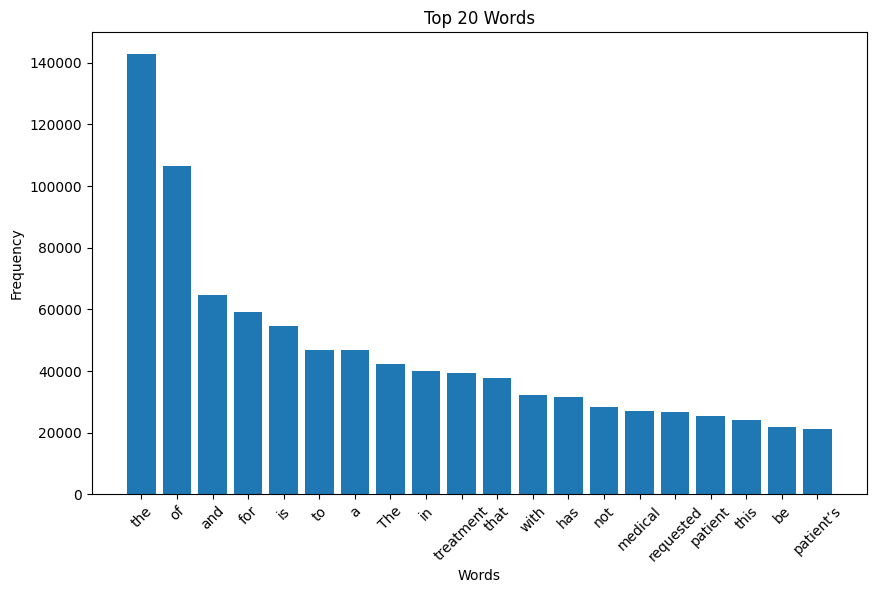

In [18]:
# Count frequency of each word
all_text = ' '.join(df_dropped['Findings'])
word_freq = Counter(all_text.split())

# Take top 20 most frequent words
top_20_words = word_freq.most_common(20)

# Visualize word frequency
words, freqs = zip(*top_20_words)
plt.figure(figsize=(10, 6))
plt.bar(words, freqs)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words')
plt.xticks(rotation=45)
plt.show()

The top 20 most frequent words from the entirety of the Summary given from the "Findings" column include:
- the
- of
- and
- for
- is
- to
- a
- The
- in
- treatment
- that
- with
- has
- not
- medical
- requested
- patient
- this
- be
- patient's

Most of these words are considered stop words, and some are even repeated words with just different capitalization.

(-0.5, 799.5, 399.5, -0.5)

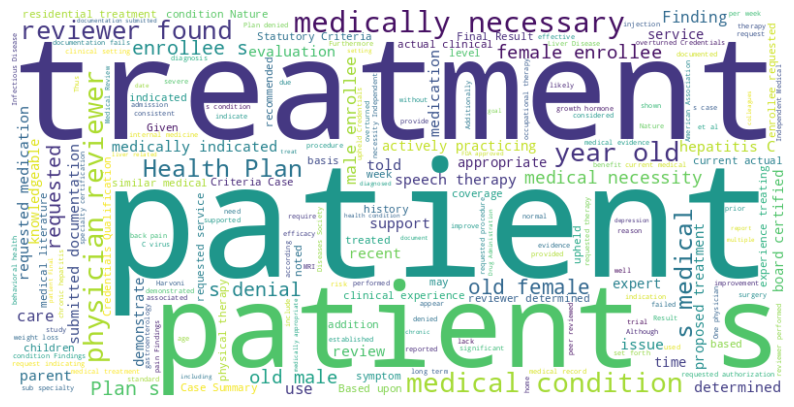

In [19]:
# Filter data to 'Medical Necessity' type
necessity_df = df_dropped[df_dropped['Type'] == 'Medical Necessity']

# Concatenate all words into one string
necessity_text = ' '.join(necessity_df['Findings'])

# Create Wordcloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(necessity_text)

# Display WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

From the "Medical Necessity" type, the most common words that can be seen from the wordcloud includes:
- treatment
- patient
- medically
- necessary
- patient's
- health plan
- medical condition
- year old
- reviewer found
- etc..

The bigger the words, the more frequent the words appear from the set of words.

(-0.5, 799.5, 399.5, -0.5)

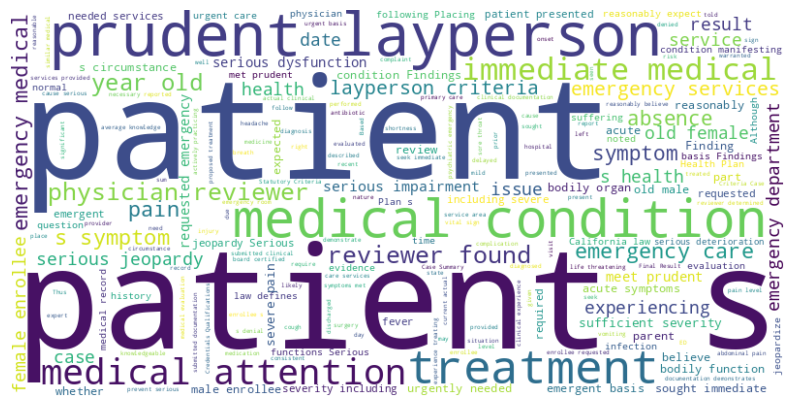

In [20]:
# Filter data to 'Urgent Care' type
urgent_df = df_dropped[df_dropped['Type'] == 'Urgent Care']

# Concatenate all words into one string
urgent_text = ' '.join(urgent_df['Findings'])

# Create Wordcloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(urgent_text)

# Display WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

From the "Urgent Care" Findings, the most common words include:
- patient's
- patient
- prudent
-layperson
- medical attention
- immediate medical
- medical condition
- etc..

(-0.5, 799.5, 399.5, -0.5)

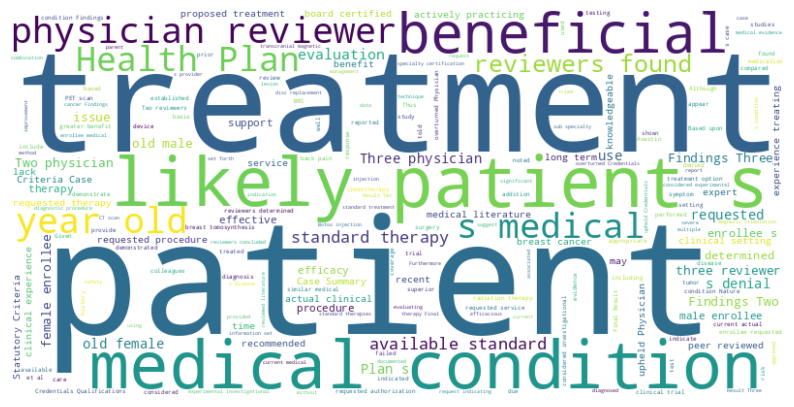

In [21]:
# Filter data to 'Experimental/Investigational' type
experimental_df = df_dropped[df_dropped['Type'] == 'Experimental/Investigational']

# Concatenate all words into one string
experimental_text = ' '.join(experimental_df['Findings'])

# Create Wordcloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(experimental_text)

# Display WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

From the "Experimental/Investigational" type, the most common words are:
- patient
- patient's
- treatment
- likely
- beneficial
- medical contidion
- etc..

# 5. Feature Engineering

### a) Take sample data for data inference and remove it from original dataset

In [22]:
# Save 1 random data from original data
data_inf = df_1.sample(1, random_state=0)
data_inf # Check that data is not missing value

,Reference ID,Report Year,Diagnosis Category,Diagnosis Sub Category,Treatment Category,Treatment Sub Category,Determination,Type,Age Range,Patient Gender,Findings
7238,EI08-8281,2008,Central Nervous System/ Neuromuscular,Other,"Diagnostic Imaging, Screening and Testing",Other,Overturned Decision of Health Plan,Experimental/Investigational,51-64,Female,A 54-year-old female enrollee has requested fo...


In [23]:
# Erase data sample from original data
df_1.drop(data_inf.index, inplace=True)

# Reset index for original data
df_1.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

# Export data Inference
data_inf.to_csv('Data_inf.csv')

### b) Missing Value Handling

> This is done first as missing values will be read as 'NaN' (float), which will make errors.

In [24]:
# Create new dataframe with only 2 columns
df_new = df_1[['Type', 'Findings']].copy()

In [25]:
# Check Missing Value in `Type`
df_new['Type'].isnull().sum().sum()

0

In [26]:
# Check Missing Value in `Findings`
df_new['Findings'].isnull().sum().sum()

20

As there are 20 missing values out of 19000+ data, the missing values will be dropped.

In [27]:
# Drop missing values from `Findings`
df_new = df_new.dropna()
df_new.isnull().sum().sum()

0

There are no more missing values, so this new dataframe can be used for the model

### c) Text Processing

In [28]:
# Create function
def text_processing(text):
  # Change to lowercase
  text = text.lower()

  # Erase \n
  text = re.sub(r"\n", " ",text)

  # Erase whitespace
  text = text.strip()

  # Erase starter phrase
  text = re.sub(r"nature of statutory criteria/case summary:", " ", text)

  # Erase symbol
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]

  # Lemmatizing
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [29]:
# Applying Text Processing to the Dataset

df_new['Findings_processed'] = df_new['Findings'].apply(lambda x:text_processing(x))
df_new

,Type,Findings,Findings_processed
0,Medical Necessity,Nature of Statutory Criteria/Case Summary: An ...,enrollee requested harvoni treatment hepatitis...
1,Medical Necessity,Nature of Statutory Criteria/Case Summary: An...,enrollee requested residential treatment cente...
2,Medical Necessity,Nature of Statutory Criteria/Case Summary: Th...,parent enrollee requested speech therapy treat...
3,Experimental/Investigational,Nature of Statutory Criteria/Case Summary: An ...,enrollee requested breast tomosynthesis evalua...
4,Experimental/Investigational,Physician 1: The patient is a 62-year-old male...,physician patient year old male reported small...
...,...,...,...
19239,Medical Necessity,The parents of a 17-year-old male requested a ...,parent year old male requested cranioplasty re...
19240,Medical Necessity,A 46-year-old male requested Penlac lacquer fo...,year old male requested penlac lacquer treatme...
19241,Medical Necessity,A 46-year-old female requested an orthoscopic ...,year old female requested orthoscopic surgery ...
19242,Medical Necessity,A 24-year-old female requested a bilateral bre...,year old female requested bilateral breast red...


### d) Target Conversion

In [30]:
# Display Target

df_new.Type.unique()

array(['Medical Necessity', 'Experimental/Investigational', 'Urgent Care'],
      dtype=object)

In [31]:
# Change Target into Number

df_new['target'] = df_new['Type'].replace({'Medical Necessity': 0, 'Experimental/Investigational': 1, 'Urgent Care': 2})
df_new

,Type,Findings,Findings_processed,target
0,Medical Necessity,Nature of Statutory Criteria/Case Summary: An ...,enrollee requested harvoni treatment hepatitis...,0
1,Medical Necessity,Nature of Statutory Criteria/Case Summary: An...,enrollee requested residential treatment cente...,0
2,Medical Necessity,Nature of Statutory Criteria/Case Summary: Th...,parent enrollee requested speech therapy treat...,0
3,Experimental/Investigational,Nature of Statutory Criteria/Case Summary: An ...,enrollee requested breast tomosynthesis evalua...,1
4,Experimental/Investigational,Physician 1: The patient is a 62-year-old male...,physician patient year old male reported small...,1
...,...,...,...,...
19239,Medical Necessity,The parents of a 17-year-old male requested a ...,parent year old male requested cranioplasty re...,0
19240,Medical Necessity,A 46-year-old male requested Penlac lacquer fo...,year old male requested penlac lacquer treatme...,0
19241,Medical Necessity,A 46-year-old female requested an orthoscopic ...,year old female requested orthoscopic surgery ...,0
19242,Medical Necessity,A 24-year-old female requested a bilateral bre...,year old female requested bilateral breast red...,0


In [32]:
# Target Distribution

df_new['target'].value_counts()

0    13581
1     5160
2      483
Name: target, dtype: int64

### e) Data Splitting

In [33]:
#Split between 'X' and 'y'

X_train_val, X_test, y_train_val, y_test = train_test_split(df_new.Findings_processed,
                                                    df_new.target,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df_new.target)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.15,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (13889,)
Val Size   :  (2451,)
Test Size  :  (2884,)


### f) Feature Encoding

In [34]:
# Change Target to One Hot Encoding

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

# 6. Model Definition

### a) Text Vectorization

In [35]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<13889x20780 sparse matrix of type '<class 'numpy.int64'>'
	with 1003895 stored elements in Compressed Sparse Row format>

In [36]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  20780
Maximum Sentence Length :  628 tokens


In [37]:
# Text Vectorization



text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,))

text_vectorization.adapt(X_train)

In [38]:
# Example Result

## Document example
print('Document example')
print(df_new.Findings_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df_new.Findings_processed[0]]))
print('Vector size : ', text_vectorization([df_new.Findings_processed[0]]).shape)

Document example
enrollee requested harvoni treatment hepatitis c virus genotype finding physician reviewer found according recent joint guideline issued american association study liver disease aasld infectious disease society america idsa patient chronic hepatitis c treated except limited life expectancy due non liver related condition applies regardless fibrosis stage viral load advanced fibrosis required treatment per guideline treatment na genotype patient treated harvoni patient viral load le iu ml treated eight week guideline recommendation based multiple randomized clinical trial kowdley et al afdhal et al moreover aasld idsa guideline cite data showing reduced survival delayed treatment jezequel et al reason requested treatment harvoni supported medically necessary treatment patient hepatitis c infection final result reviewer determined requested medication medically necessary treatment patient medical condition therefore health plan denial overturned credential qualification 

In [39]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'patient',
 'treatment',
 'medical',
 'requested',
 'therapy',
 'reviewer',
 'condition',
 'enrollee',
 'physician',
 'year',
 'medically',
 'health',
 'old',
 'plan',
 'found',
 'finding',
 'necessary',
 'pain']

### b) Word Embedding

In [40]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [41]:
# Example Result

## Document example
print('Document example')
print(df_new.Findings_processed[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df_new.Findings_processed[0]]))
print('Vector size : ', text_vectorization([df_new.Findings_processed[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df_new.Findings_processed[0]])))
print('Vector size : ', embedding(text_vectorization([df_new.Findings_processed[0]])).shape)

Document example
enrollee requested harvoni treatment hepatitis c virus genotype finding physician reviewer found according recent joint guideline issued american association study liver disease aasld infectious disease society america idsa patient chronic hepatitis c treated except limited life expectancy due non liver related condition applies regardless fibrosis stage viral load advanced fibrosis required treatment per guideline treatment na genotype patient treated harvoni patient viral load le iu ml treated eight week guideline recommendation based multiple randomized clinical trial kowdley et al afdhal et al moreover aasld idsa guideline cite data showing reduced survival delayed treatment jezequel et al reason requested treatment harvoni supported medically necessary treatment patient hepatitis c infection final result reviewer determined requested medication medically necessary treatment patient medical condition therefore health plan denial overturned credential qualification 

In [42]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [43]:
## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(3, activation='softmax'))

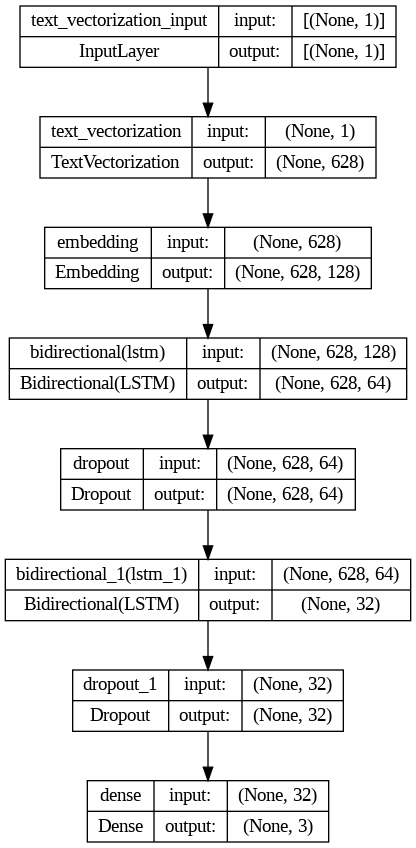

In [44]:
tf.keras.utils.plot_model(model_lstm_1, show_shapes=True)

# 7. Model Training

In [45]:
# Model Training using LSTM
%%time

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=15, validation_data=(X_val, y_val_ohe))

Epoch 1/15
435/435 [==============================] - 75s 147ms/step - loss: 0.2259 - accuracy: 0.9239 - val_loss: 0.0726 - val_accuracy: 0.9825
Epoch 2/15
435/435 [==============================] - 44s 101ms/step - loss: 0.0619 - accuracy: 0.9844 - val_loss: 0.0790 - val_accuracy: 0.9808
Epoch 3/15
435/435 [==============================] - 37s 85ms/step - loss: 0.0313 - accuracy: 0.9935 - val_loss: 0.0720 - val_accuracy: 0.9808
Epoch 4/15
435/435 [==============================] - 39s 90ms/step - loss: 0.0302 - accuracy: 0.9924 - val_loss: 0.0949 - val_accuracy: 0.9759
Epoch 5/15
435/435 [==============================] - 37s 84ms/step - loss: 0.0315 - accuracy: 0.9932 - val_loss: 0.1534 - val_accuracy: 0.9621
Epoch 6/15
435/435 [==============================] - 36s 83ms/step - loss: 0.0174 - accuracy: 0.9968 - val_loss: 0.0743 - val_accuracy: 0.9829
Epoch 7/15
435/435 [==============================] - 35s 80ms/step - loss: 0.0120 - accuracy: 0.9983 - val_loss: 0.0751 - val_accurac

# 8. Model Evaluation

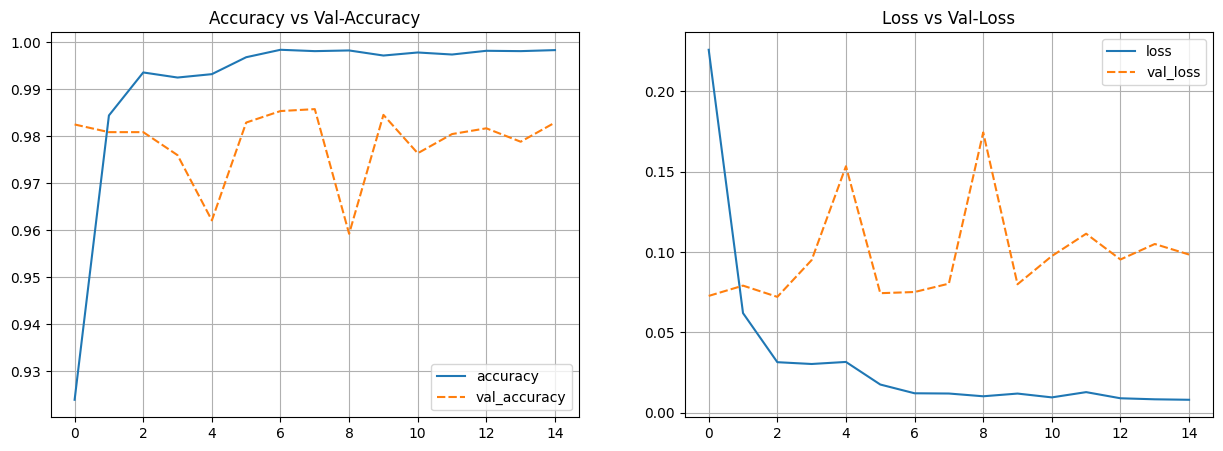

In [46]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

From the charts, it can be seen that the train accuracy is better than the val accuracy, though the difference is within 2% only. Same goes with loss, where the val loss is more unstable than the train loss. Both seems to have less than 1% loss which is good, but since the validation set is worse than the train set, it can be a bit overfit.

In [47]:
# Show Dataframe of Results
model_lstm_1_hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.225892,0.923897,0.072620,0.982456
1,0.061912,0.984376,0.079025,0.980824
2,0.031348,0.993520,0.072027,0.980824
3,0.030230,0.992440,0.094937,0.975928
4,0.031507,0.993160,0.153359,0.962056
5,0.017444,0.996760,0.074320,0.982864
6,0.011988,0.998344,0.075056,0.985312
7,0.011840,0.998056,0.080259,0.985720
8,0.010125,0.998200,0.174422,0.959200
9,0.011809,0.997120,0.079862,0.984496


In [48]:
# Predict Test-set
y_pred = model_lstm_1.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

91/91 [==============================] - 6s 44ms/step


In [49]:
# Classification report
print(classification_report(y_test_ohe, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2037
           1       0.98      0.98      0.98       774
           2       0.91      0.92      0.91        73

   micro avg       0.99      0.99      0.99      2884
   macro avg       0.96      0.96      0.96      2884
weighted avg       0.99      0.99      0.99      2884
 samples avg       0.99      0.99      0.99      2884



# Improvement of LSTM with Transfer Learning

In [50]:
# Download the Embedding Layer

url = 'https://tfhub.dev/google/tf2-preview/nnlm-id-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [51]:
# Model Training using LSTM with Transfer Learning
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(3, activation='softmax'))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_2_hist = model_lstm_2.fit(X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe))

Epoch 1/50
435/435 [==============================] - 20s 32ms/step - loss: 0.7020 - accuracy: 0.7078 - val_loss: 0.6518 - val_accuracy: 0.7177
Epoch 2/50
435/435 [==============================] - 12s 28ms/step - loss: 0.6454 - accuracy: 0.7179 - val_loss: 0.6484 - val_accuracy: 0.6785
Epoch 3/50
435/435 [==============================] - 13s 29ms/step - loss: 0.6202 - accuracy: 0.7265 - val_loss: 0.5979 - val_accuracy: 0.7315
Epoch 4/50
435/435 [==============================] - 12s 27ms/step - loss: 0.6000 - accuracy: 0.7373 - val_loss: 0.6074 - val_accuracy: 0.7340
Epoch 5/50
435/435 [==============================] - 10s 24ms/step - loss: 0.5745 - accuracy: 0.7521 - val_loss: 0.5890 - val_accuracy: 0.7434
Epoch 6/50
435/435 [==============================] - 11s 26ms/step - loss: 0.5103 - accuracy: 0.7848 - val_loss: 0.4846 - val_accuracy: 0.7874
Epoch 7/50
435/435 [==============================] - 12s 27ms/step - loss: 0.4780 - accuracy: 0.7980 - val_loss: 0.4880 - val_accuracy:

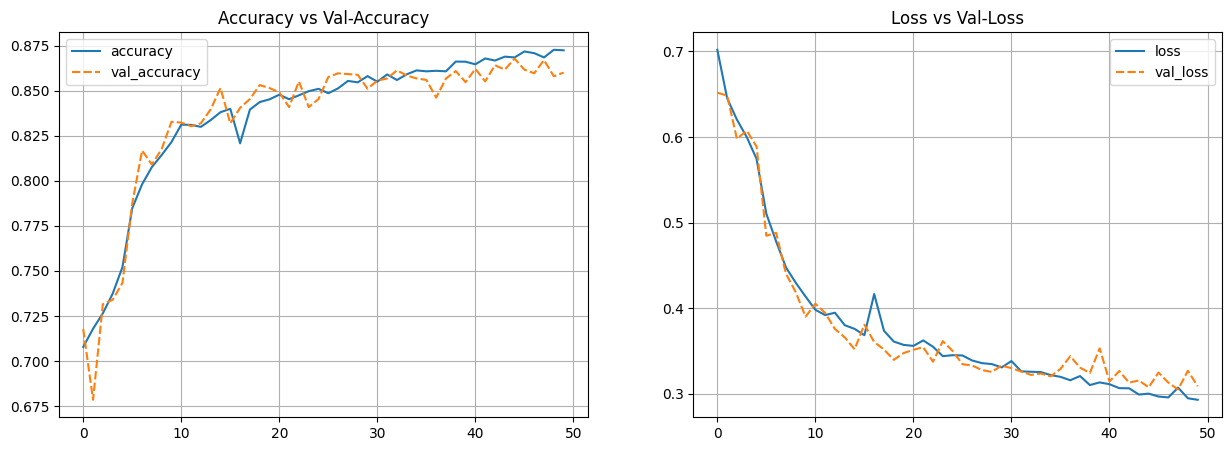

In [52]:
# Plot Training Results

model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [53]:
# Predict Test-set
y_pred_2 = model_lstm_2.predict(X_test)
y_pred_2 = np.where(y_pred_2 >= 0.5, 1, 0)

91/91 [==============================] - 2s 11ms/step


In [54]:
# Classification report
print(classification_report(y_test_ohe, y_pred_2))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2037
           1       0.86      0.64      0.74       774
           2       0.86      0.75      0.80        73

   micro avg       0.87      0.87      0.87      2884
   macro avg       0.86      0.78      0.82      2884
weighted avg       0.87      0.87      0.86      2884
 samples avg       0.87      0.87      0.87      2884



From the new model, it can be seen that the train accuracy and the val accuracy are very similar and close, same goes with the train loss and val loss. This is considered a good fit model, even though the accuracy for both train and val is less than 90%. As a conclusion, while it seems to be a trial, the first model is the better model which will be used for model saving.

# 9. Model Saving

In [55]:
# Model Summary
model_lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 628)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 628, 128)          2659840   
                                                                 
 bidirectional (Bidirection  (None, 628, 64)           41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 628, 64)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                        

In [56]:
# Freeze Model
model_lstm_1.trainable = True

# Save the model
model_lstm_1.save('model')

# Directory name of model name
model_dir = 'model'

# Save model as TensorFlow SavedModel
model_lstm_1.save(model_dir, save_format='tf')

# Compress directory model into ZIP file
shutil.make_archive(model_dir, 'zip', model_dir)

# Download file
files.download(f'{model_dir}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 10. Model Inference

> Model Inference will be done in a separate notebook titled `P2G7_Audrey_Wanto.ipynb`.

# 11. Conclusion

- From the original dataset, out of the 11 columns, only one column was used for modelling and analysis, which was the `Findings` column.
- There were missing values (less than 50) within the `Findings` column, which were then removed as there were already more than 19000 data.
- From text processing, the text were all lowercased, erased new line, whitespace, starter phrase, and symbols. They were then tokenized, the stopwords were removed, and the words were also lemmatized (the lower the amount of vocabulary, the better).
- Out of the 19000+ data, 15% were dedicated to Test set, and another 15% of the remaining 85% of the data were dedicated to Validation set. Everything else was then dedicated for the Train set.
- The target (`Type` column) was encoded using to_categorical() function as it was a multiclass classification.
- For the model definition, the text was first vectorized and then embedded.
- When training the model, LSTM was used. LSTM is a type of RNN used to process NLP data. They are used to train, predict, and classify sequential data. In this case, it is applied for classification using a similar method to sentiment analysis.
- Through the model evaluation, it can be seen that the precision, recall, and f1-score of the model are almost all above 90%, with 99% being the highest value, and 88% being the lowest value.
- While although the validation set seems to have a little bit worse values compared to the training set, the test set proves that the model works extremely well.
- After trial and error using LSTM with Transfer Learning, it was determined that the original model had better results than the one with transfer learning.
- The transfer learning LSTM model had a good fit, but had precision, accuracy, and f1-score worse than the original model (ranging within 70-80%).
- The original model only needed 15 epochs to reach a desirable results, while the second model (transfer learning) needed 50 epochs and still did not have desirable results.
- From the model inference, it can be seen that the model works properly as it predicted the right `Type`.